In [55]:
# calibration scatter plot of binned predicted vs true coefficients for semi-synthetic data
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from data import *
import os
import seaborn as sns
plt.rcParams['font.family'] = 'serif'

# Set the font used for math expressions to LaTeX
plt.rcParams["mathtext.fontset"] = "cm"

In [56]:
# file paths
base_file = '/share/garg/311_data/sb2377/clean_codebase/three_year_base.csv'
coeffs_file = '/share/garg/311_data/sb2377/clean_codebase/semisynthetic/semisynthetic_coeffs.csv'
results_dir = '/share/garg/311_data/sb2377/results'

# user specified arguments
types = {'Street': 'StreetConditionDOT',
         'Park': 'MaintenanceorFacilityDPR',
         'Rodent': 'RodentDOHMH',
         'Food': 'FoodDOHMH',
         'DCWP': 'ConsumerComplaintDCWP'}
normalized_covariates = ['normalized_log_population_density',
                         'normalized_log_income_median',
                         'normalized_education_bachelors_pct',
                         'normalized_race_white_nh_pct',
                         'normalized_age_median',
                         'normalized_households_renteroccupied_pct',
                         'semisynthetic_type_specific_rating']
job_ids = [i * 3 + 3200 for i in range(20)]
epoch = '59'

# plotting parameters
figsize=(6, 4.5)
num_bins_theta = 20
num_bins_alpha = 5
save_path = "/home/sb2377/gnn_crowdsourced_model/figures/semisynthetic_coefficients.pdf"

In [57]:
# load files
base_df = pd.read_csv(base_file)
coeff_df = pd.read_csv(coeffs_file)

In [58]:
# get type indices
type_df = base_df[['typeagency', 'type_idxs']].drop_duplicates()
indices = {}
for type_name, type_id in types.items():
    idx = type_df[type_df['typeagency'] == type_id]['type_idxs'].iloc[0]
    indices[type_name] = idx

In [ ]:
# get predicted coefficients for all jobs
checkpoint_file = '{}/job{}/model-epoch={}.ckpt'
checkpoint_counter = 0
pred_coeffs = []
true_coeffs = []

for i, job_id in enumerate(job_ids):
    if os.path.exists(checkpoint_file.format(results_dir, job_id, epoch)):
        checkpoint_counter += 1

        # get predicted coefficient
        checkpoint = torch.load(checkpoint_file.format(results_dir, job_id, epoch), map_location=torch.device('cpu'))
        intercept = checkpoint['state_dict']['pt_layer_bias']
        coeff = checkpoint['state_dict']['pt_layer']
        pred_coeff = torch.cat([intercept, coeff], dim=1)[:, 1:]
        pred_coeffs.append(pred_coeff.unsqueeze(axis=0))
        
        # get true coefficient
        thetas = ['theta.{}_{}'.format(j, i) for j in range(1, len(normalized_covariates) + 1)]
        true_coeff = coeff_df[thetas].drop_duplicates().values.squeeze()
        true_coeffs.append(np.expand_dims(true_coeff, axis=0))

pred_coeffs = np.concatenate(pred_coeffs, axis=0)
true_coeffs = np.concatenate(true_coeffs, axis=0)

time_all_coeffs = pred_coeffs
time_true_all_coeffs = true_coeffs

print('checkpoint files done = {}'.format(checkpoint_counter)) 

checkpoint files done = 20


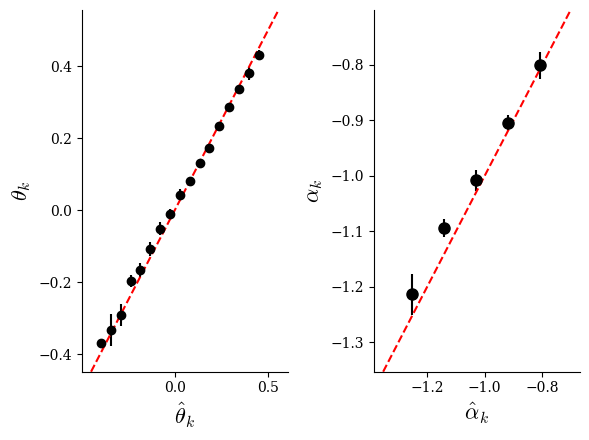

In [65]:
# plot figure
def calibration_vals(true, pred, num_bins):
    bins = np.linspace(true.min(), true.max(), num_bins + 1)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    mean_values = []
    cis = []

    for i in range(len(bins) - 1):
        mask = (true >= bins[i]) & (true < bins[i+1])
        bin_values = pred[mask]

        if len(bin_values) > 1:
            mean_values.append(np.mean(bin_values))
            se = np.std(bin_values) / np.sqrt(len(bin_values) - 1)
            cis.append(1.96 * se)
        else:
            mean_values.append(np.nan)
            cis.append(np.nan)

    mean_values = np.array(mean_values)
    cis = np.array(cis)
    return bin_centers, mean_values, cis

fig, ax = plt.subplots(1, 2, figsize=figsize)

# get theta (demographic coefficients)
pred_theta = pred_coeffs[:, list(indices.values()), :-1].flatten()
true_theta = true_coeffs[:, list(indices.values()), :-1].flatten()
bin_centers, mean_values, cis = calibration_vals(true_theta, pred_theta, num_bins_theta)
ax[0].errorbar(bin_centers, mean_values, yerr=cis, fmt='o', color='black', markersize=6, linestyle='none')

# plot y=x line
min_val = np.minimum(np.nanmin(bin_centers), np.nanmin(mean_values))
max_val = np.maximum(np.nanmax(bin_centers), np.nanmax(mean_values))
ax[0].plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

# Set the same x and y limits
ax[0].set_ylim(min_val, max_val)

# get alpha (rating coefficient)
pred_alpha = pred_coeffs[:, list(indices.values()), -1].flatten()
true_alpha = true_coeffs[:, list(indices.values()), -1].flatten()
bin_centers, mean_values, cis = calibration_vals(true_alpha, pred_alpha, num_bins_alpha)
ax[1].errorbar(bin_centers, mean_values, yerr=cis, fmt='o', color='black', markersize=8, linestyle='none')

# plot y=x line
min_val = np.minimum(np.nanmin(bin_centers), np.nanmin(mean_values))-0.1
max_val = np.maximum(np.nanmax(bin_centers), np.nanmax(mean_values))+0.1
ax[1].plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

# Set the same x and y limits
ax[1].set_ylim(min_val, max_val)

ax[0].set_xlabel(r'$\hat{\theta}_k$', fontsize=16)
ax[0].set_ylabel(r'$\theta_k$', fontsize=16)
ax[1].set_xlabel(r'$\hat{\alpha}_k$', fontsize=16)
ax[1].set_ylabel(r'$\alpha_k$', fontsize=16)

sns.despine()

plt.tight_layout()
# plt.savefig(save_path, format="pdf", bbox_inches="tight")